# Measurements of CPU <-> DPU Bandwidth

All measurements were carried out on the following system

- Dual Socket Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz
- Sub-NUMA clustering enabled
- HyperThreading disabled
- There are four memory controllers (two per socket). Each has:
  - Channel 0: 1 Legacy DIMM with 64 GB Ram
  - Channel 1: 2 UpMem DIMMs
  - Channel 2: 2 UpMem DIMMs

- Ubuntu 22.04.4 LTS / GCC 11

In almost all cases we measure only transfers between memory areas of the same memory controller (though in parallel on all controllers). Exceptions:
- All runs that were compiled against the original UpMem binary library (`shipped`)
- Broadcasts in the `Broadcast` benchmark

Transfers are always issued to all ranks (`prepare` & `push`) and we measure the accumulated bandwidth as the number of bytes written or read from the all active DPUs. Most of the improvements can also be applied for the new `_sg_`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme()

def load_file(path):
    data = pd.read_json(path, lines=True)

    data["total_bytes"] = data.bytes_per_dpu * data.dpus
    data["bench"] = data["mode"]
    data["bench"] = data["mode"].str.cat(data["aligned"].map({0: "U", 1: "A"}), sep=" ")
    data.loc[data["mode"] == "Scatter2Per8", "total_bytes"] /= 4
    data.loc[data["mode"] == "Scatter4Per8", "total_bytes"] /= 2
    data["bandwidth"] = data.total_bytes / data.seconds
    data["bandwidth_gbs"] = data.bandwidth / 1e9
    data["pool"] = data.profile.map(lambda x: int(x.split(",")[0].split("=")[1]))
    assert np.all(data.profile.map(lambda x: "Pool" in x.split(",")[0]))

    return data


frames = []
for file in Path("data").glob("*.csv"):
    data = load_file(file)
    revision = file.name.replace("state_", "").replace(".csv", "")
    data["revision"] = revision
    frames.append(data)

data = pd.concat(frames)


## Software revisions
We compare several software revisions; they correspond to the branches of the same name in the `libdpu` [repository](https://github.com/manpen/upmem-libdpu).
All changes are incremental, in the sense that latter revision include all changes as reported earlier. They are:

- `shipped`: Binary version of the library as provided by UpMem
- `unmodified`: Same as shipped, but compiled myself
- `replace_avxgather`: Replaces the avx gather implementation with a faster instruction sequence
- `write_512b_to_bank`: When writing to DPUs fetch 8 cache lines and use avx instruction to transpose them
- `write_to_rank_broadcast`: Detect and accelerate transfer where all DPUs within a bank receive the same data
- `experimental_read`: Applies techniques in the same spirit as above to reading data from DPUs. **WARNING:** I use non-temporal reads to access mram. From my understanding of streaming reads this eliminates the need of cache invalidation + volatile reads. But this assessment might be wrong! 


## Shipped vs. unmodified

First question: Is the performance of the binary `libdpu` (as downloaded from the official website) comparable to the version I compiled myself from the unmodified official sources?

I ran all benchmarks (details discussed below) against both libraries and obtained similar results; the small difference can be explained by the fact that the benchmark with the shipped version cannot obtain NUMA information for the ranks and therefore cannot assign memory controller local.

In the following, I assume that all measurements obtained for `unmodified` are virtually identical for the supplied binary version of the library.




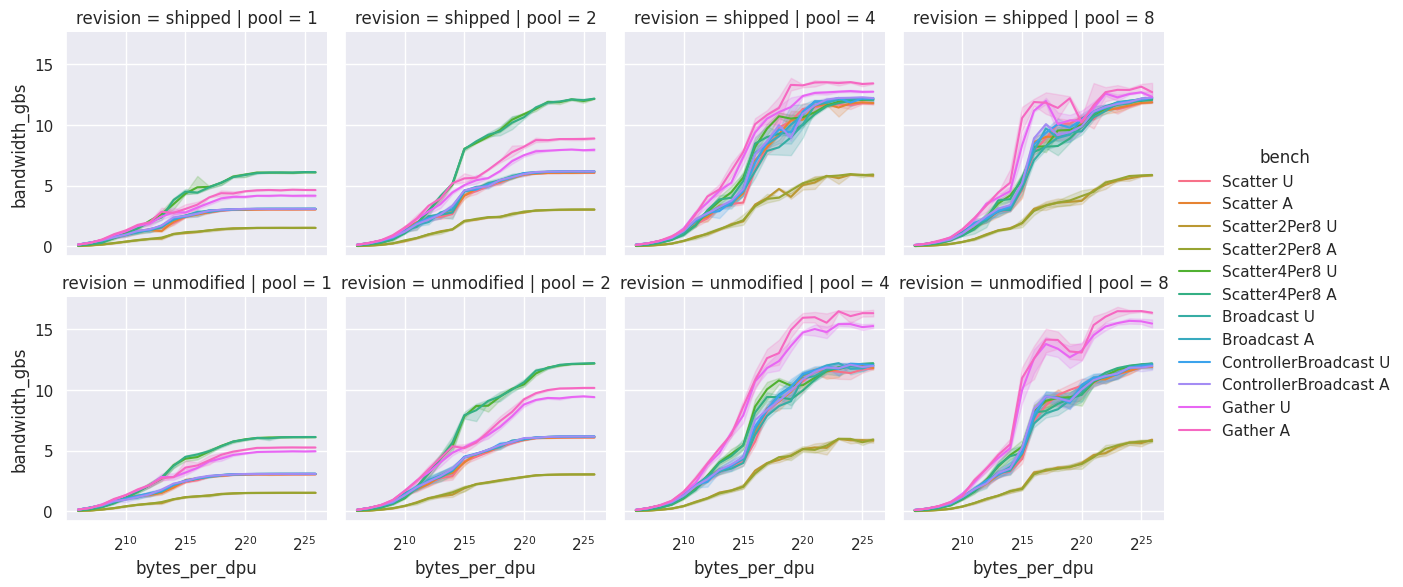

In [2]:
view = data[data["revision"].apply(lambda x: x in ["shipped", "unmodified"])]
f = sns.FacetGrid(view, row="revision", col="pool", hue="bench")
f.map(sns.lineplot, "bytes_per_dpu", "bandwidth_gbs")
plt.semilogx(base=2)
f.add_legend()
plt.show()


## Writing to DPUs

Let's consider a couple of work loads to write data to DPUs:

1.) `Scatter`: We want to send an individual chunk of data to each DPU, i.e. we want to *scatter* the data.
    The the sources reside in the legacy DIMM at the same memory controller the receiving ranks are connected at.
    There are three variants of the benchmark: `Scatter`, `Scatter2Per8` and `Scatter4Per8`. 
    In each benchmark all banks (groups of 8 DPUs) are targeted. In `Scatter` we write to all DPUs, in the remaining two we "randomly" select 2 or 4 DPUs per bank.


2.) `Broadcast`: We want to broadcast the same data to all DPUs (e.g., as in the `checksum` example). 
    The `Broadcast` benchmark assumes that the data resides in one place on the host on one memory controller; i.e. 3/4 of the system needs to talk to a foreign memory controller. The benchmark `BroadcastController` assumes that we have four copies of the data --- one per memory controller.


The source data is either *aligned* (to 64b cache lines) or `unaligned` (= aligned to 8b but NOT 64b).
The alignment is indicated in the title as an `A` or `U` suffix.

### 1.) Scatter

For the remainder, we use the following figure style: 

Each benchmark type gets its own row. 
We repeat each setting with 1, 2, 4 and 8 threads per pool; these are the columns.
Then, each figure has the transfer size per DPU in bytes (as specified to the `push` command) on its x-axis.
On the y-axis we indicate the bandwidth (number of total bytes written or read to/from all DPUs divided by the runtime between the first `prepare` call and a `sync` command).
All measurements are repeated at least 5 times; their spread is indicated via the confidence interval.


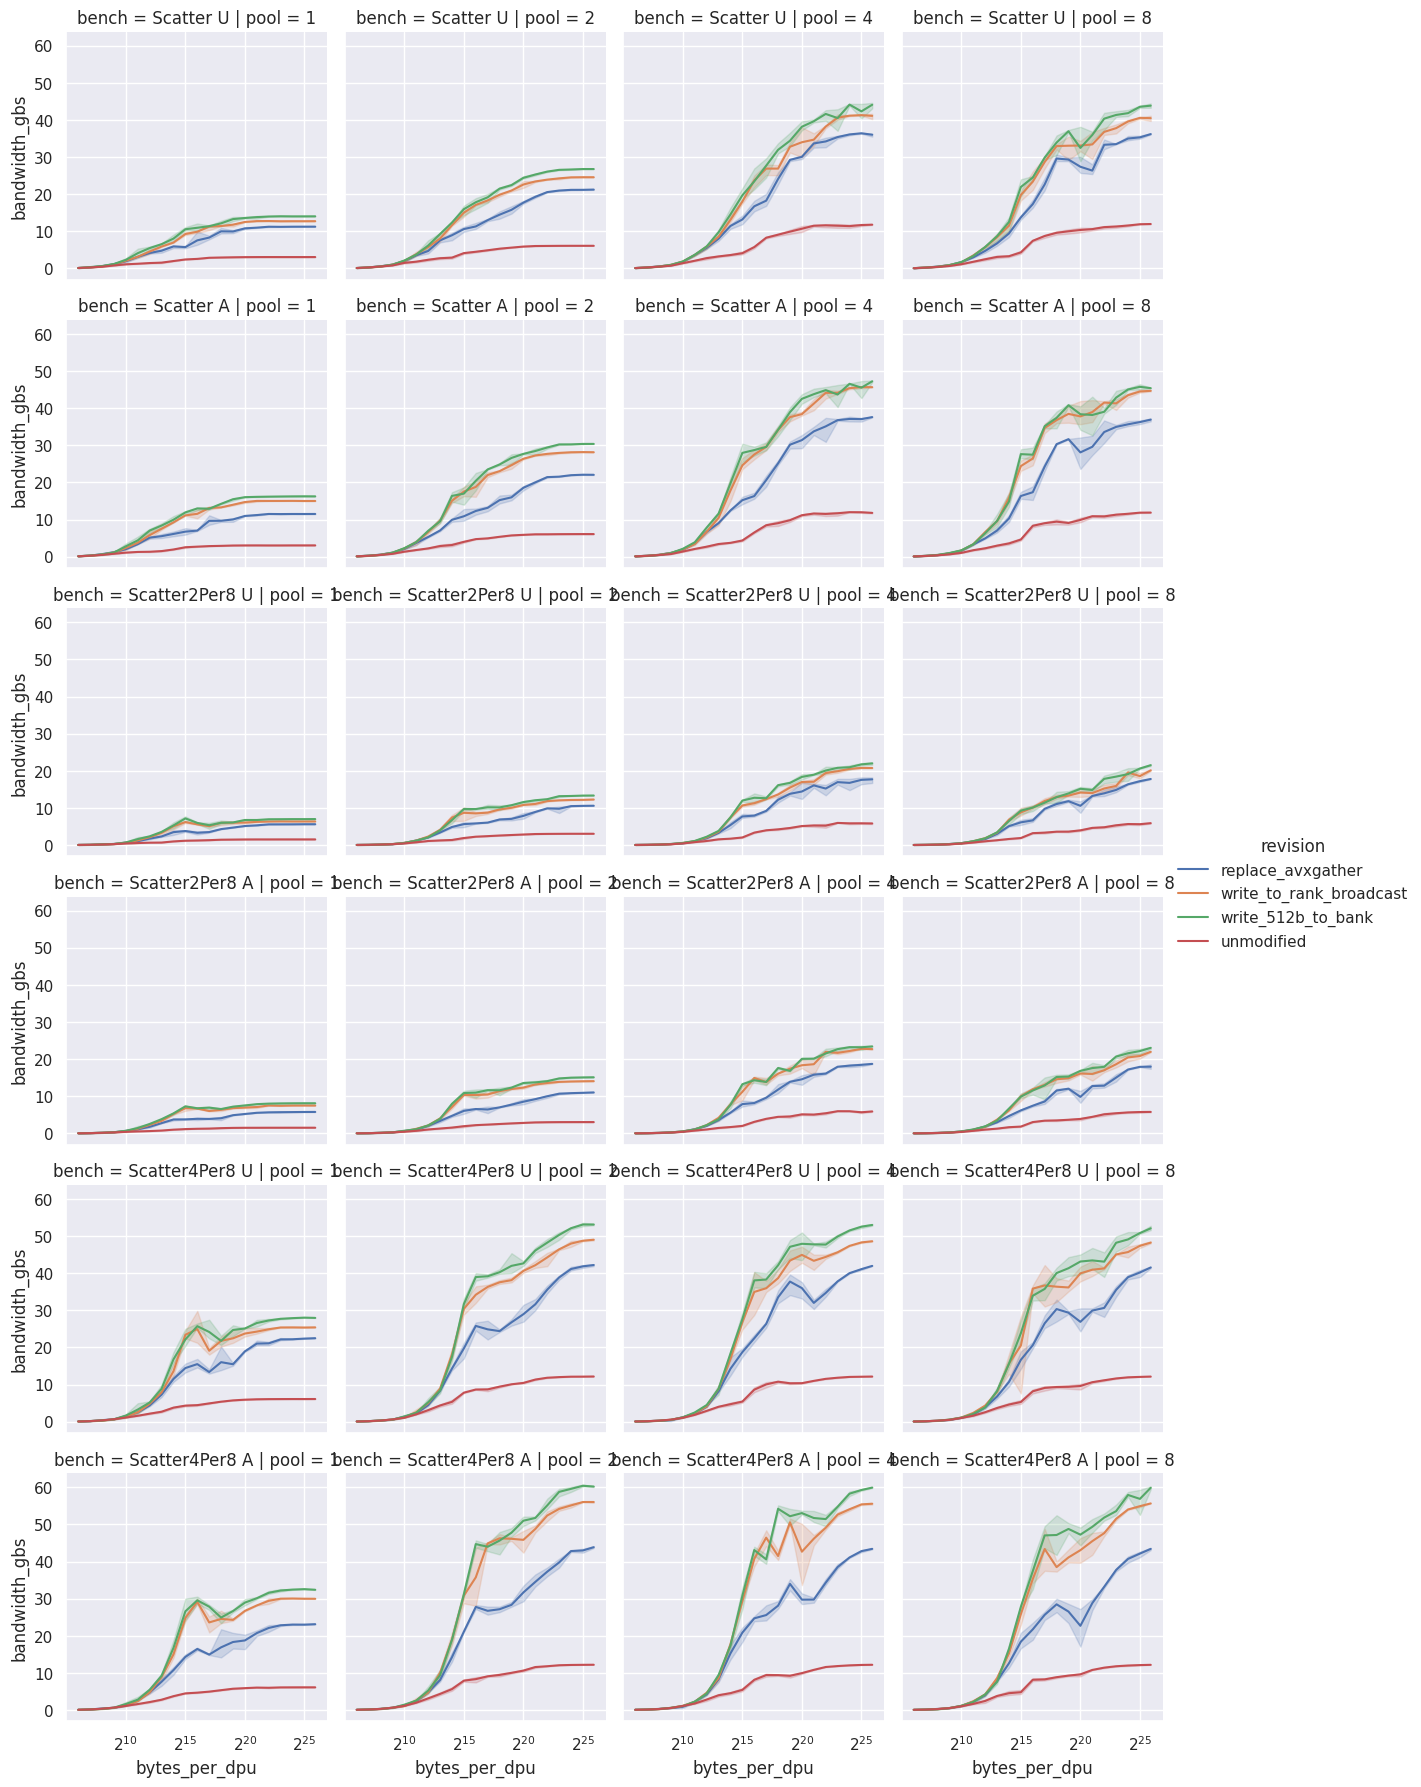

In [3]:
view = data[data["revision"].apply(lambda x: x not in ["shipped", "experimental_read"]) & data["bench"].apply(lambda x: "Scatter" in x)]
f = sns.FacetGrid(view, row="bench", col="pool", hue="revision")
f.map(sns.lineplot, "bytes_per_dpu", "bandwidth_gbs")
plt.semilogx(base=2)
f.add_legend()
plt.show()


#### Performance between code revisions
Clearly, the shipped version is drastically outperformed by all revisions.
The largest single impact is to replace the avx gather instruction with a sequence of cheaper load/permute instructions. 
The next plus comes from fetching whole cache lines from the source and doing a matrix transposition instead of 8 separate `byte_interleave`.
Lastly, there clearly is some cost attributed to check whether the broadcast fast-path (see below) is applicable (though I'm surprised by the extent and would assume that there's something else going on).

#### Alignment
Reading from aligned memory locations results in approximately 10% higher bandwidth when using AVX512 loads.
It might be interesting to advise users to use 64b alignment for the inputs where possible.
One could also offer a `profile` option, to opt into alignment checks.

#### Differences between benchmarks
For each transaction in `Scatter2Per8` two source buffers have to be read. Then for each word written to a bank, only 25% of data counts towards useful bandwidth.
For this reason, `Scatter2Per8` is the slowest of the three benchmarks.

For `Scatter`, every byte written to a bank counts towards the bandwidth. Still, it is slower than `Scatter4Per8`. This suggests that reading the data is the actual bottleneck: for `Scatter` we need to read from 8 positions, for `Scatter4Per8` only from four. 


## 2.) Broadcast

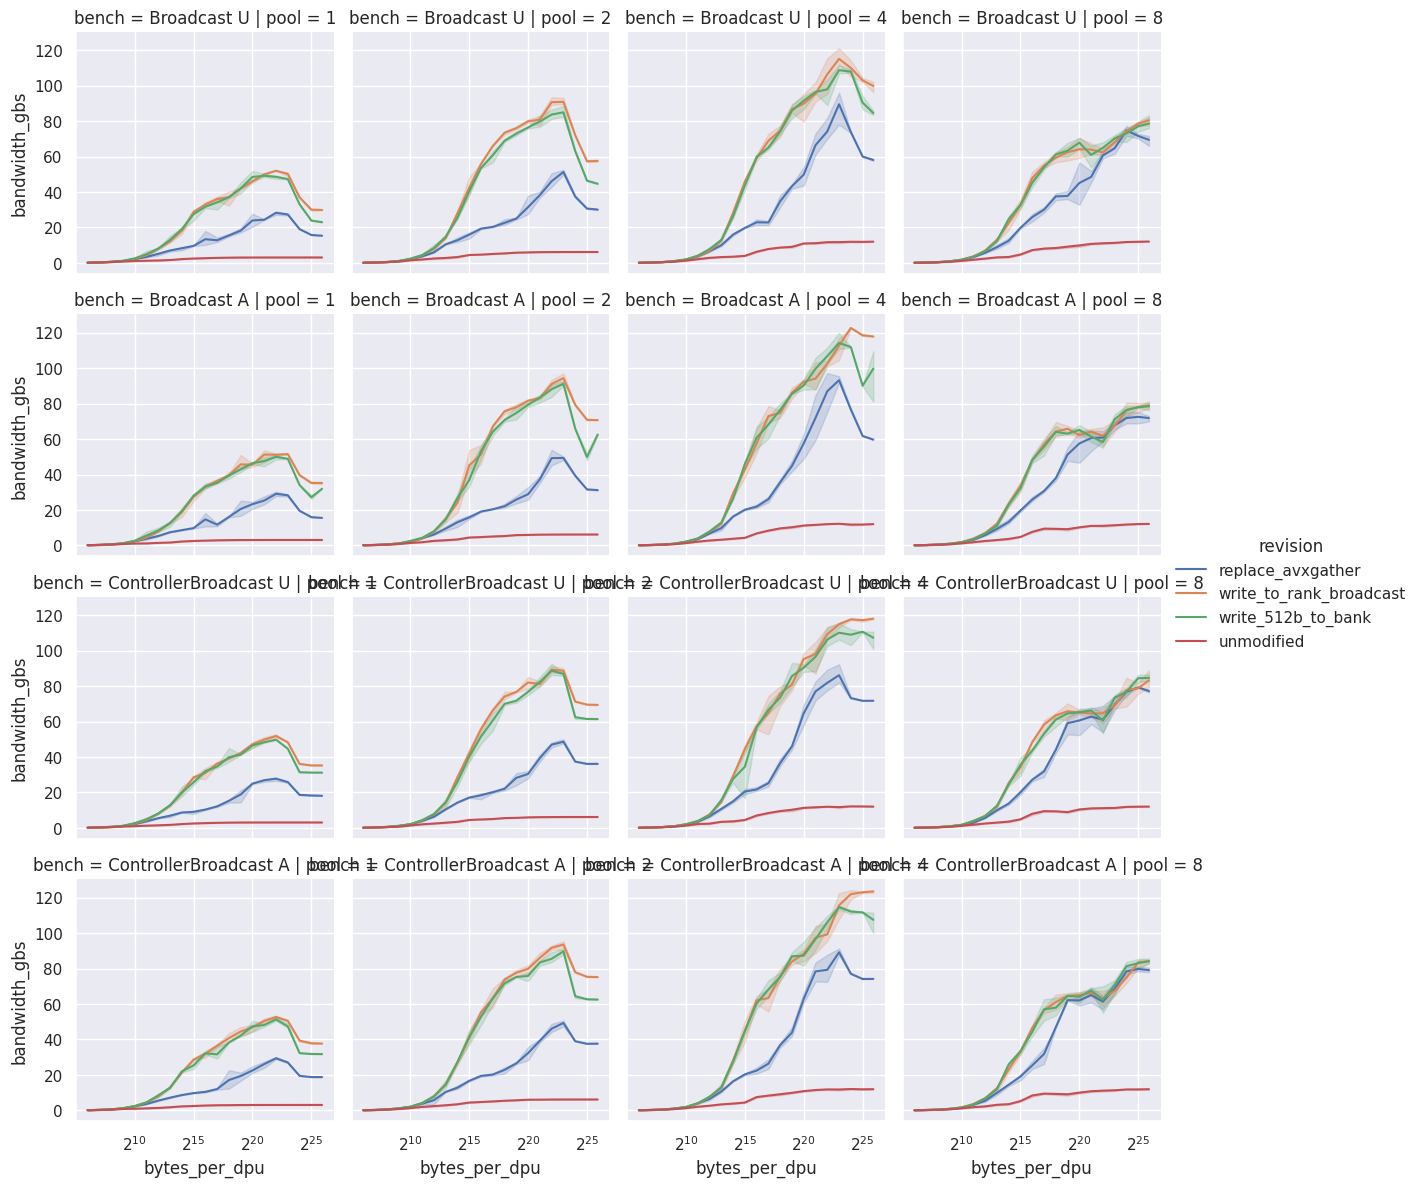

In [4]:
view = data[data["revision"].apply(lambda x: x not in ["shipped", "experimental_read"]) & data["bench"].apply(lambda x: "Broadcast" in x)]
f = sns.FacetGrid(view, row="bench", col="pool", hue="revision")
f.map(sns.lineplot, "bytes_per_dpu", "bandwidth_gbs")
plt.semilogx(base=2)
f.add_legend()
plt.show()


The revision `write_to_rank_broadcast` adds another check to the transfer function: for each bank, we check whether all pointers in the transfer matrix point to the same source (this will be tricky for the _sg_ functions). If all non-null sources are identical, we read this source only once an avoid the matrix transposition. The resulting implementation is sometimes faster than `write_512b_to_rank`, but the results are quite small. It might be worth avoiding the broadcast runtime check and instead set a dedicated flag, if we copy to a rank `dpuset` (i.e. check once before the copy rather than multiple times during). Also, it might be faster to read whole cacheline instead of single 64bit words.

**Unknown**: I do not understand the drop in performance for transfer sizes approaching 64MB. They most certainly are related to L3 cache effects, but I do not fully understand the mechanism.